In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from surprise import Dataset
from surprise import Reader
from surprise import KNNWithMeans
from surprise.model_selection import cross_validate
#from surprise.model_selection import KFold
from surprise.model_selection.search import GridSearchCV
from surprise.model_selection import PredefinedKFold
from surprise import accuracy
from surprise.model_selection import train_test_split

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

In [46]:
movieData = pd.read_csv('ml-latest-small/ratings.csv')
movieData.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [3]:
users = movieData['userId'].values
movies = movieData['movieId'].values
ratings = movieData['rating'].values

In [4]:
#ratings.shape

In [5]:
#movies

### Q1 
Compute the sparsity of the movie rating dataset, where spar-sity is defined by equation 1

In [6]:
print('Sparsity is {:.4f}'.format(len(ratings) / (len(set(movies)) * len(set(users)))))

Sparsity is 0.0170


### Q2
Plot a histogram showing the frequency of the rating values. To be specific, bin the rating values into intervals of width 0.5 and use the binned rating values as the horizontal axis. Count the number of entries in the ratings matrix R with rating values in the binned intervals and use this count as the vertical axis. Briefly comment on the shape of the histogram

No handles with labels found to put in legend.


5.0


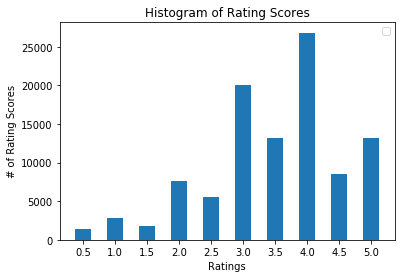

In [7]:
print(max(ratings))
labels = np.unique(ratings)

fig, ax = plt.subplots()
ax.bar(np.arange(len(labels)), np.unique(ratings, return_counts = True)[1], 0.5)

ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.legend()

plt.title("Histogram of Rating Scores")
plt.xlabel("Ratings")
plt.ylabel("# of Rating Scores")

plt.show()

In [8]:
#np.arange(0,6,0.5)
#np.sum(ratings<=0.5)

In [9]:
# hist=plt.hist(ratings-0.5,bins=np.arange(0,5.5,0.5))
# plt.xlabel('rating',fontsize=15)
# plt.ylabel('counts',fontsize=15)
# plt.title('rating histogram',fontsize=15)

### Q3
Plot the distribution of the number of ratings received among movies. To be specific, the X-axis should be the movie index ordered by decreasing frequency and the Y -axis should be the number of ratings the movie has received. For example, the movie that has the largest number of ratings has index 1; ties can broken in any way. A monotonically decreasing curve instead of a histogram is expected.

In [10]:
len(movieData.query('movieId ==6'))
# It seems the movieID defined in this problem is different than the movieID defined in the dataset. Why would we do this?

102

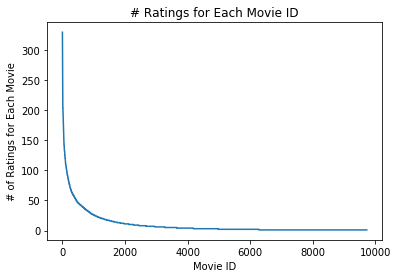

In [11]:
get = np.unique(movies, return_counts = True)

plt.plot(range(len(get[0])), -np.sort(-get[1]))
plt.title('# Ratings for Each Movie ID')
plt.xlabel('Movie ID')
plt.ylabel('# of Ratings for Each Movie')
plt.show()

### Q4
Plot the distribution of ratings among users. To be specific, the X-axis should be the user index ordered by decreasing frequency and the Y -axis should be the number of movies the user have rated. The requirement of the plot is similar to that in Question 3. 

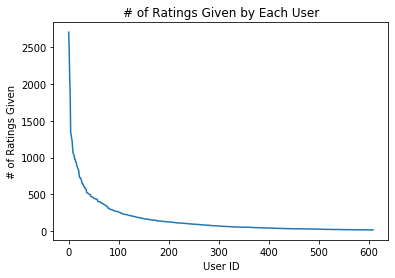

In [12]:
# But the userID here does not correlate to the userID in the orignal dataset, why would we do this?
get = np.unique(users, return_counts = True)

plt.plot(range(len(get[0])), -np.sort(-get[1]))
plt.title('# of Ratings Given by Each User')
plt.xlabel('User ID')
plt.ylabel('# of Ratings Given')
plt.show()

### Question 5: 
Explain the salient features of the distribution found in question 3 and their implications for the recommendation process.

### Sol:
Very few movies received enough ratings. Most movies have lots of unspecified ratings from users and the rating matrix will be sparse. It's necassary to fill in those unspecified ratings by prediction using collaborative filtering.

### Q6
Compute the variance of the rating values received by each movie. Then, bin the variance values into intervals of width 0.5 and use the binned variance values as the horizontal axis. Count the number of movies with variance values in the binned intervals and use this count as the vertical axis. Briefly comment on the shape of the histogram 

No handles with labels found to put in legend.


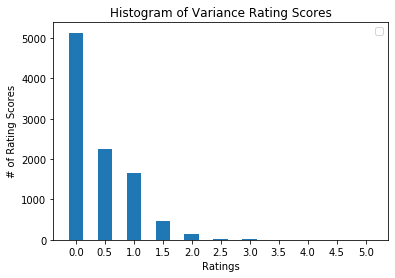

In [14]:
variance = np.var(movieData.pivot_table('rating','userId','movieId'), axis = 0)
variance = round(variance * 2)/2

labels = np.unique(variance)

fig, ax = plt.subplots()
ax.bar(np.arange(len(labels)), np.unique(variance, return_counts = True)[1], 0.5)

ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.legend()

plt.title("Histogram of Variance Rating Scores")
plt.xlabel("Ratings")
plt.ylabel("# of Rating Scores")

plt.show()

Text(0.5, 1.0, 'movie rating variance histogram')

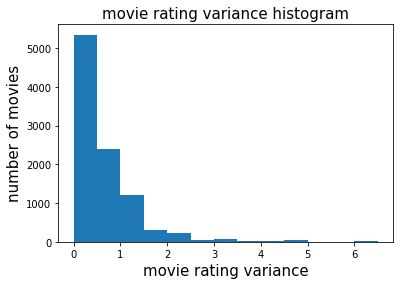

In [16]:
# Just double check the answer
rating_variance=np.nan_to_num(movieData.groupby('movieId').var()['rating'])
plt.hist(rating_variance,bins=np.arange(0,7,0.5))
plt.xlabel('movie rating variance',fontsize=15)
plt.ylabel('number of movies',fontsize=15)
plt.title('movie rating variance histogram',fontsize=15)

### Question 7: 
Write down the formula for lu in terms of Iu and ruk

Pearson-correlation coefficient between users u and v, denoted by Pearson(u,v), captures the similarity between the rating vectors of users u and v. Before stat- ing the formula for computing Pearson(u,v), let’s first introduce some notation:
* Iu : Set of item indices for which ratings have been specified by user u 
* Iv : Set of item indices for which ratings have been specified by user v 
* μu: Mean rating for user u computed using her specified ratings
* ruk: Rating of user u for item k


#### Ans 
$μ_u=mean(\sum_{k\in I_u}r_{uk})$

## Question 8

In plain words, explain the meaning of Iu ∩ Iv. Can Iu ∩ Iv = ∅
(Hint: Rating matrix R is sparse). 

### Ans
Iu ∩ Iv means the set of movies that receive ratings from both user u and user v. It's possible that Iu ∩ Iv = ∅ since the rating matrix is so sparse. Some users can have no common-rated movie at all.


## Question 9
Can you explain the reason behind mean-centering the raw ratings (rvj − μv) in the prediction function? (Hint: Consider users who either rate all items highly or rate all items poorly and the impact of these users on the prediction function) 

### Ans
After mean-centering, what's left in the ratings is one user's preference variance across different movies. We can capture some similarity between two users according to their preference across movies. A person rating all movies with high scores has high correlation with a person rating all movies with low scores. In some way, it's providing similarity information for different movies.


### Q10

Design a k-NN collaborative filter to predict the ratings of the movies in the MovieLens dataset and evaluate it’s performance using 10-fold cross validation. Sweep k (number of neighbors) from 2 to 100 in step sizes of 2, and for each k compute the average RMSE and average MAE obtained by averaging the RMSE and MAE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis) and average MAE (Y-axis) against k (X-axis).

* Surprise https://surprise.readthedocs.io/en/stable/getting_started.html#tune-algorithm-parameters-with-gridsearchcv

In [17]:
reader = Reader(line_format = 'user item rating timestamp', sep = ',', rating_scale = (0.5, 5), skip_lines=1)

In [18]:
#reader.indexes

In [19]:
reader = Reader(line_format = 'user item rating timestamp', sep = ',', rating_scale = (0.5, 5), skip_lines=1)
movieDataset = Dataset.load_from_file('ml-latest-small/ratings.csv', reader = reader)

rmse = []
mae = []

for i in range(2,102,2):
    knnModel = KNNWithMeans(k = i, sim_options = {'name': 'pearson', 'user_based': True}, verbose = False)
    cv = cross_validate(knnModel, movieDataset, measures = ['RMSE','MAE'], cv = 10, verbose = False,n_jobs = -2) # use all but 2 CPUs
    rmse.append(np.mean(cv['test_rmse']))
    mae.append(np.mean(cv['test_mae']))
    if i%10==0:
        print('Finished k value: ', i)

Finished k value:  10
Finished k value:  20
Finished k value:  30
Finished k value:  40
Finished k value:  50
Finished k value:  60
Finished k value:  70
Finished k value:  80
Finished k value:  90
Finished k value:  100


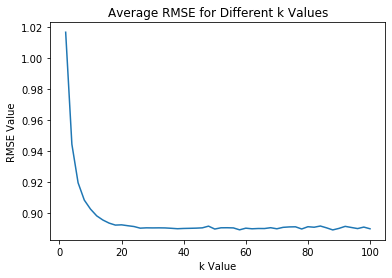

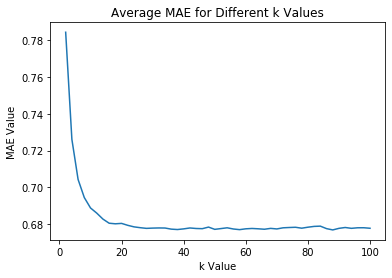

In [20]:
kVals = range(2,102,2)

plt.plot(kVals, rmse)
plt.title('Average RMSE for Different k Values')
plt.xlabel('k Value')
plt.ylabel('RMSE Value')
plt.show()

plt.plot(kVals, mae)
plt.title('Average MAE for Different k Values')
plt.xlabel('k Value')
plt.ylabel('MAE Value')
plt.show()

### Q11
Use the plot from question 10, to find a 'minimum k'. Note: The term 'minimum k' in this context means that increasing k above the minimum value would not result in a significant decrease in average RMSE or average MAE. If you get the plot correct, then 'minimum k' would correspond to the k value for which average RMSE and average MAE converges to a steady-state value. Please report the steady state values of average RMSE and average MAE.

In [21]:
bestK = 0
for k in range(0,len(rmse)-1):
    if(rmse[k+1] < rmse[k]):
        bestK += 2
    else:
        print("Minimum k: ", bestK)
        print("Average RMSE at minimum k: ", rmse[k])
        print("Average MAE at minimum k: ", rmse[k])
        break

Minimum k:  16
Average RMSE at minimum k:  0.8921202628399374
Average MAE at minimum k:  0.8921202628399374


I think the minimum k should be at least 25, 18 seems not completely convergent.

### Some update for Q12-14
Q12-14 the code seem a little bit repetitive, maybe combine them into one code

In [62]:
from sklearn.model_selection import KFold
import os

def define_folds(movieDataset,trim=None):
    popular_movies = movieDataset.groupby('movieId').filter(lambda x: x['rating'].count()>2)['movieId'].unique()
    unpopular_movies = movieDataset.groupby('movieId').filter(lambda x: x['rating'].count()<=2)['movieId'].unique()
    high_var_movies=movieDataset.groupby('movieId').filter(lambda x: (x['rating'].count()>=5) 
                                                      & (x['rating'].var(ddof=0)>=2))['movieId'].unique()
    if not trim: trim='no_trim' 
    if not os.path.isdir(trim): os.makedirs(trim) 
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    folds_files=[]
    for i,(train_index, test_index) in enumerate(kf.split(movieDataset)):
        X_train, X_test = movieDataset.iloc[train_index], movieDataset.iloc[test_index]
        if trim=='popular': X_test=X_test[X_test['movieId'].isin(popular_movies)]
        elif trim=='unpopular': X_test=X_test[X_test['movieId'].isin(unpopular_movies)]
        elif trim=='high_var': X_test=X_test[X_test['movieId'].isin(high_var_movies)]
        train_file,test_file=trim+'/trainset_{:}.csv'.format(i),trim+'/testset_{:}.csv'.format(i)
        X_train.to_csv(train_file,header=False,index=False)
        X_test.to_csv(test_file,header=False,index=False)
        folds_files.append((train_file,test_file))
    return folds_files

In [63]:

# df -> dataset (cv,fold...) -> trainset (fit) -> testset (test)
def algo_cv(model,movieDataset,k_list,trim=None,**kwargs):
    reader = Reader(line_format='user item rating timestamp', sep=',',rating_scale=(0.5, 5))
    folds_files=define_folds(movieDataset,trim)
    data = Dataset.load_from_folds(folds_files, reader)
    pkf = PredefinedKFold()
    mean_RMSE = []
    mean_MAE =[]
    for k in k_list:
        #print('k (number of neighbors) = {}'.format(i))
        #algo = model(k, random_state=42, shuffle=True, **kwargs)
        if k% 10==0:
            print('k (number of neighbors) = {}'.format(k))
        algo = model(k, random_state=42, **kwargs)
        ret = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=pkf, verbose=False, n_jobs=-2)
        mean_RMSE.append(np.mean(ret['test_rmse']))
        mean_MAE.append(np.mean(ret['test_mae'])) 

    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(8,3))
    ax1.plot(k_list,mean_RMSE,label='mean rmse')
    ax1.set_xlabel('number of neighbors k')
    ax1.legend()
    ax2.plot(k_list,mean_MAE,label='mean mae')
    ax2.set_xlabel('number of neighbors k')
    ax2.legend()
    if trim:
        plt.suptitle('trimmed testset on '+trim+', minimum average RMSE: {:.4f}'.format(np.min(mean_RMSE)))
    else:
        plt.suptitle('No trim on testset on, minimum average RMSE: {:.4f}'.format(np.min(mean_RMSE)))
    return mean_RMSE, mean_MAE    

### Q12

Design a k-NN collaborative filter to predict the ratings of the movies in the popular movie trimmed test set and evaluate it's performance using 10-fold cross validation. Sweep k (number of neighbors) from 2 to 100 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE.

Wall time: 8min 17s


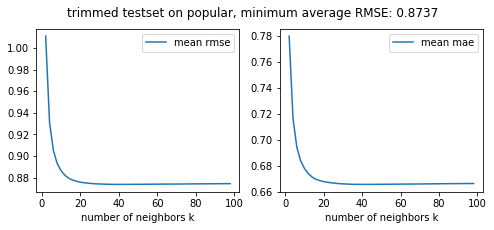

In [31]:
%%time
model=KNNWithMeans
k_list=list(range(2,100,2))
#rmse,mae=algo_cv(model,movieDataset,k_list,trim=None,sim_options={'name': 'pearson','user_based': True},verbose=False)
rmse_pop,mae_pop=algo_cv(model,movieData,k_list,trim='popular',sim_options={'name': 'pearson','user_based': True},verbose=False)

### Q13

Design a k-NN collaborative filter to predict the ratings of the movies in the unpopular movie trimmed test set and evaluate it's performance using 10-fold cross validation. Sweep k (number of neighbors) from 2 to 100 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE.

Wall time: 7min 2s


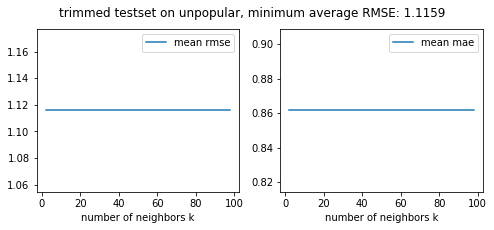

In [35]:
%%time
model=KNNWithMeans
k_list=list(range(2,100,2))
rmse_unpop,mae_unpop=algo_cv(model,movieData,k_list,trim='unpopular',sim_options={'name': 'pearson','user_based': True},verbose=False)

### Q14
Design a k-NN collaborative filter to predict the ratings of the movies in the high variance movie trimmed test set and evaluate it's performance using 10-fold cross validation. Sweep k (number of neighbors) from 2 to 100 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k(X-axis). Also, report the minimum average RMSE.

Wall time: 6min 51s


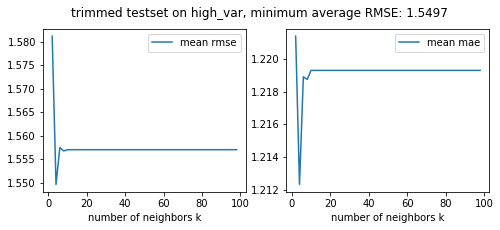

In [37]:
%%time
model=KNNWithMeans
k_list=list(range(2,100,2))
rmse_high_var,mae_hig_var=algo_cv(model,movieData,k_list,trim='high_var',sim_options={'name': 'pearson','user_based': True},verbose=False)

## Michael's original solution ----------------

### Q12

Design a k-NN collaborative filter to predict the ratings of the movies in the popular movie trimmed test set and evaluate it's performance using 10-fold cross validation. Sweep k (number of neighbors) from 2 to 100 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE.

In [12]:
kf = KFold(n_splits = 10)
overallRMSE = [] 

for i in range(2,102,2):
    knnModel = KNNWithMeans(k = i, sim_options = {'name': 'pearson', 'user_based': True}, verbose = False)
    rmse = []
    for trainData, testData in kf.split(movieDataset):
        movieIds = []
        trimTestData = []
        
        for tupleVal in testData:
            movieIds.append(tupleVal[1])
            
        get = np.unique(movieIds, return_counts = True)
        
        for tupleVal in testData:
            if(get[1][np.where(get[0] == tupleVal[1])[0][0]] > 2):
                trimTestData.append(tupleVal)
            
        knnModel.fit(trainData)
        predictions = knnModel.test(trimTestData)
        rmse.append(accuracy.rmse(predictions, verbose=False))
        
    overallRMSE.append(np.mean(rmse))
    if i%10 ==0:
        print('Finished k value: ', i)

Finished k value:  2
Finished k value:  4
Finished k value:  6
Finished k value:  8
Finished k value:  10
Finished k value:  12
Finished k value:  14
Finished k value:  16
Finished k value:  18
Finished k value:  20
Finished k value:  22
Finished k value:  24
Finished k value:  26
Finished k value:  28
Finished k value:  30
Finished k value:  32
Finished k value:  34
Finished k value:  36
Finished k value:  38
Finished k value:  40
Finished k value:  42
Finished k value:  44
Finished k value:  46
Finished k value:  48
Finished k value:  50
Finished k value:  52
Finished k value:  54
Finished k value:  56
Finished k value:  58
Finished k value:  60
Finished k value:  62
Finished k value:  64
Finished k value:  66
Finished k value:  68
Finished k value:  70
Finished k value:  72
Finished k value:  74
Finished k value:  76
Finished k value:  78
Finished k value:  80
Finished k value:  82
Finished k value:  84
Finished k value:  86
Finished k value:  88
Finished k value:  90
Finished k val

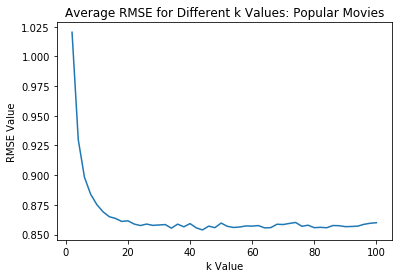

0.8539042262217093


In [13]:
plt.plot(kVals, overallRMSE)
plt.title('Average RMSE for Different k Values: Popular Movies')
plt.xlabel('k Value')
plt.ylabel('RMSE Value')
plt.show()

print(min(overallRMSE))

### Q13

Design a k-NN collaborative filter to predict the ratings of the movies in the unpopular movie trimmed test set and evaluate it's performance using 10-fold cross validation. Sweep k (number of neighbors) from 2 to 100 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE.

In [14]:
kf = KFold(n_splits = 10)
overallRMSE = [] 

for i in range(2,102,2):
    knnModel = KNNWithMeans(k = i, sim_options = {'name': 'pearson', 'user_based': True}, verbose = False)
    rmse = []
    for trainData, testData in kf.split(movieDataset):
        movieIds = []
        trimTestData = []
        
        for tupleVal in testData:
            movieIds.append(tupleVal[1])
            
        get = np.unique(movieIds, return_counts = True)
        
        for tupleVal in testData:
            if(get[1][np.where(get[0] == tupleVal[1])[0][0]] <= 2):
                trimTestData.append(tupleVal)
        
        knnModel.fit(trainData)
        predictions = knnModel.test(trimTestData)
        rmse.append(accuracy.rmse(predictions, verbose=False))
        
    overallRMSE.append(np.mean(rmse))
    if i%10 ==0:
        print('Finished k value: ', i)

Finished k value:  2
Finished k value:  4
Finished k value:  6
Finished k value:  8
Finished k value:  10
Finished k value:  12
Finished k value:  14
Finished k value:  16
Finished k value:  18
Finished k value:  20
Finished k value:  22
Finished k value:  24
Finished k value:  26
Finished k value:  28
Finished k value:  30
Finished k value:  32
Finished k value:  34
Finished k value:  36
Finished k value:  38
Finished k value:  40
Finished k value:  42
Finished k value:  44
Finished k value:  46
Finished k value:  48
Finished k value:  50
Finished k value:  52
Finished k value:  54
Finished k value:  56
Finished k value:  58
Finished k value:  60
Finished k value:  62
Finished k value:  64
Finished k value:  66
Finished k value:  68
Finished k value:  70
Finished k value:  72
Finished k value:  74
Finished k value:  76
Finished k value:  78
Finished k value:  80
Finished k value:  82
Finished k value:  84
Finished k value:  86
Finished k value:  88
Finished k value:  90
Finished k val

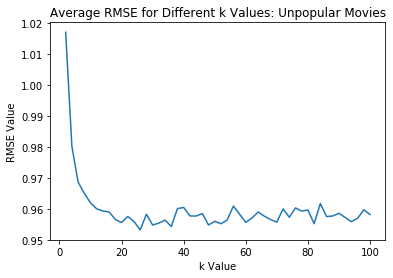

0.9531859470657424


In [15]:
plt.plot(kVals, overallRMSE)
plt.title('Average RMSE for Different k Values: Unpopular Movies')
plt.xlabel('k Value')
plt.ylabel('RMSE Value')
plt.show()

print(min(overallRMSE))

### Q14
Design a k-NN collaborative filter to predict the ratings of the movies in the high variance movie trimmed test set and evaluate it's performance using 10-fold cross validation. Sweep k (number of neighbors) from 2 to 100 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k(X-axis). Also, report the minimum average RMSE.

In [16]:
kf = KFold(n_splits = 10)
overallRMSE = [] 

for i in range(2,102,2):
    knnModel = KNNWithMeans(k = i, sim_options = {'name': 'pearson', 'user_based': True}, verbose = False)
    rmse = []
    for trainData, testData in kf.split(movieDataset):
        movieIds = []
        trimTestData = []
        variances = []
        
        for tupleVal in testData:
            movieIds.append(tupleVal[1])
            
        get = np.unique(movieIds, return_counts = True)
        
        for id in movieIds:
            getRatings = []
            for tupleVal in testData:
                if(tupleVal[1] == id):
                    getRatings.append(tupleVal[2])
            variances.append(np.var(getRatings))
        
        for tupleVal in testData:
            if(get[1][np.where(get[0] == tupleVal[1])[0][0]] >= 5 and variances[np.where(get[0] == tupleVal[1])[0][0]] >= 2):
                trimTestData.append(tupleVal)
        
        knnModel.fit(trainData)
        predictions = knnModel.test(trimTestData)
        rmse.append(accuracy.rmse(predictions, verbose=False))
        
    overallRMSE.append(np.mean(rmse))
    if i%10 ==0:
        print('Finished k value: ', i)

Finished k value:  2
Finished k value:  4
Finished k value:  6
Finished k value:  8
Finished k value:  10
Finished k value:  12
Finished k value:  14
Finished k value:  16
Finished k value:  18
Finished k value:  20
Finished k value:  22
Finished k value:  24
Finished k value:  26
Finished k value:  28
Finished k value:  30
Finished k value:  32
Finished k value:  34
Finished k value:  36
Finished k value:  38
Finished k value:  40
Finished k value:  42
Finished k value:  44
Finished k value:  46
Finished k value:  48
Finished k value:  50
Finished k value:  52
Finished k value:  54
Finished k value:  56
Finished k value:  58
Finished k value:  60
Finished k value:  62
Finished k value:  64
Finished k value:  66
Finished k value:  68
Finished k value:  70
Finished k value:  72
Finished k value:  74
Finished k value:  76
Finished k value:  78
Finished k value:  80
Finished k value:  82
Finished k value:  84
Finished k value:  86
Finished k value:  88
Finished k value:  90
Finished k val

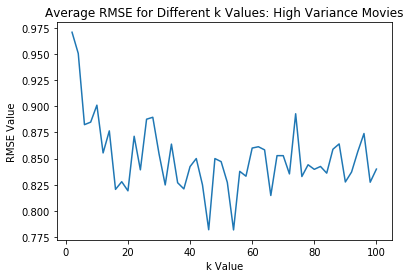

0.7817946599146941


In [17]:
plt.plot(kVals, overallRMSE)
plt.title('Average RMSE for Different k Values: High Variance Movies')
plt.xlabel('k Value')
plt.ylabel('RMSE Value')
plt.show()

print(min(overallRMSE))

## Michael's original solution ----------------End

### Q15

Plot the ROC curves for the k-NN collaborative filter designed in question 10 for threshold values [2:5; 3; 3:5; 4]. For the ROC plotting use the k found in question 11. For each of the plots, also report the area under the curve (AUC) value.

For the ROC plotting, split the dataset into 90% for training and 10% for testing. For solving question 15 the functions described in the documentation below might be useful.

In [82]:
def plot_roc_curve(model,movieDataset):
    ratingThresholds = [2.5,3,3.5,4]
    fprs = []
    tprs = []
    aucs = []

    #bestK = 30
    #knnModel = KNNWithMeans(k = bestK, sim_options = {'name': 'pearson', 'user_based': True}, verbose = False)
    trainData, testData = train_test_split(movieDataset)
    model.fit(trainData)
    predictions = model.test(testData)

    for threshold in ratingThresholds:
        binaryEstimate = []
        estimate = []

        for i in range(len(predictions)):
            estimate.append(predictions[i].est)
            if testData[i][2] >= threshold:
                binaryEstimate.append(1)
            else:
                binaryEstimate.append(0)

        fpr, tpr, _ = roc_curve(binaryEstimate, estimate)
        auc = roc_auc_score(binaryEstimate, estimate)

        fprs.append(fpr)
        tprs.append(tpr)
        aucs.append(auc)

        print("finished for rating threshold: ", threshold)

    return fprs,tprs,aucs

finished for rating threshold:  2.5
finished for rating threshold:  3
finished for rating threshold:  3.5
finished for rating threshold:  4


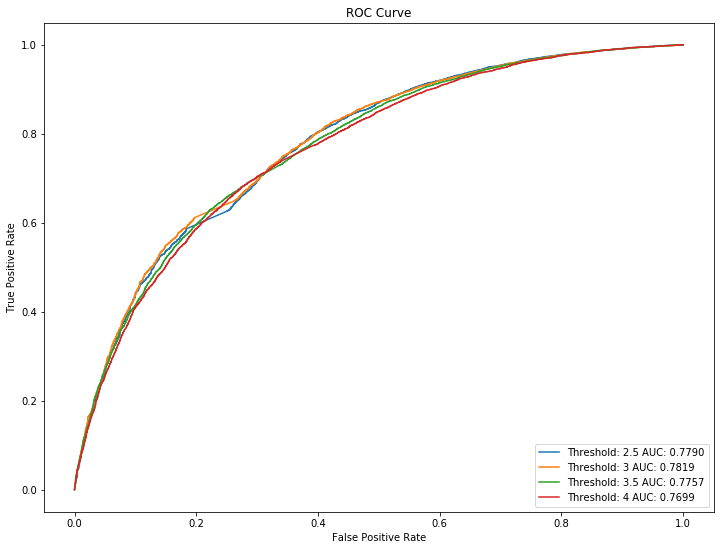

In [84]:

knnModel = KNNWithMeans(k = 18, sim_options = {'name': 'pearson', 'user_based': True}, verbose = False)
fprs,tprs,aucs = plot_roc_curve(knnModel,movieDataset)


plt.figure(figsize=(12,9))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
for i in range(len(fprs)):
    plt.plot(fprs[i], tprs[i], label = 'Threshold: {:} AUC: {:.4f}'.format(ratingThresholds[i], aucs[i]) )
plt.legend(loc="lower right")
plt.show()

### Question 16: 
Is the optimization problem given by equation 5 convex? Consider the optimization problem given by equation 5. For U fixed, formulate it as a least-squares problem.

It's not convex, because the Hessian matrix for the equation is not positive definite (think about (1-xy)^2). However, if we fix U, the process of solving for V is a least-square problem. Same thing for solving for U if we fix V. If we fix U, the problem becomes

$$\underset{V}{minimize}\sum_{i=1}^m\sum_{j=1}^nW_{ij}(r_{ij}-(UV^T)_{ij})^2$$

### Question 17: 
Design a NNMF-based collaborative filter to predict the ratings of the movies in the MovieLens dataset and evaluate it's performance using 10-fold cross-validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE and average MAE obtained by averaging the RMSE and MAE across all 10 folds. Plot the average RMSE (Y-axis) against k (X-axis) and the average MAE (Y-axis) against k (X-axis). For solving this question, use the default value for the regularization parameter.

Wall time: 15min 38s


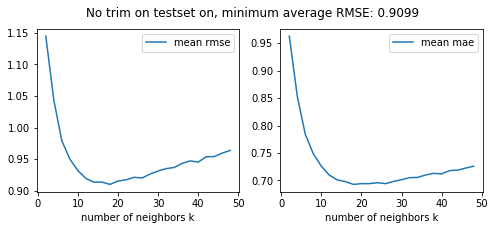

In [49]:
%%time
from surprise.prediction_algorithms.matrix_factorization import NMF
model=NMF #only takes int, not np.int
k_list=list(range(2,50,2))
rmse_NMF,mae_NMF=algo_cv(model,movieData,k_list,trim=None)
print('Q18, min rmse is {:.4f} at k={:} latent factors, min mae is {:.4f} at k={:} latent factors.'.format(
    np.min(rmse_NMF),k_list[np.argmin(rmse_NMF)],np.min(mae_NMF),k_list[np.argmin(mae_NMF)]),
      '\nAccording to readme file there are 18 movie genres')

In [55]:
#plt.plot(rmse)

### Question 18: 
Use the plot from question 17, to find the optimal number of latent factors. Optimal number of latent factors is the value of k that gives the minimum average RMSE or the minimum average MAE. Please report the minimum average RMSE and MAE. Is the optimal number of latent factors same as the number of movie genres?

### Sol:
min rmse is 0.9144 at k=16 latent factors, min mae is 0.6941 at k=24 latent factors. 
According to readme file there are 18 movie genres

### Q19
Design a NNMF collaborative filter to predict the ratings of the movies in the popular movie trimmed test set and evaluate it's performance using 10-fold cross validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE.

k (number of neighbors) = 3
k (number of neighbors) = 3
k (number of neighbors) = 3
k (number of neighbors) = 3
min rmse is 0.8891 at k=18 latent factors, min mae is 0.6782 at k=18 latent factors.
Wall time: 16min 4s


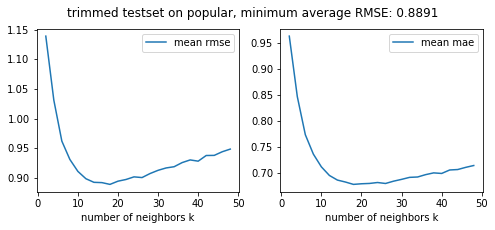

In [61]:
%%time
# the output k in this code is incorrect
from surprise.prediction_algorithms.matrix_factorization import NMF
model=NMF #only takes int, not np.int
k_list=list(range(2,50,2))
rmse_pop,mae_pop=algo_cv(model,movieData,k_list,trim='popular')

print('min rmse is {:.4f} at k={:} latent factors, min mae is {:.4f} at k={:} latent factors.'.format(
    np.min(rmse_pop),k_list[np.argmin(rmse_pop)],np.min(mae_pop),k_list[np.argmin(mae_pop)]))

### Q20
Design a NNMF collaborative filter to predict the ratings of the movies in the unpopular movie trimmed test set and evaluate it's performance using 10-fold cross validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE.

k (number of neighbors) = 10
k (number of neighbors) = 20
k (number of neighbors) = 30
k (number of neighbors) = 40
min rmse is 1.1748 at k=46 latent factors, min mae is 0.9079 at k=48 latent factors.
Wall time: 16min 36s


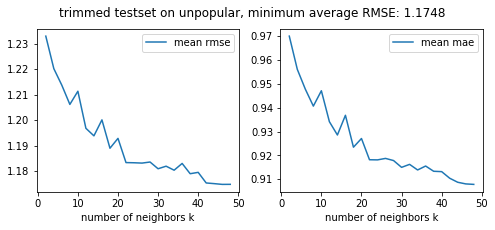

In [64]:
%%time
# the output k in this code is incorrect
from surprise.prediction_algorithms.matrix_factorization import NMF
model=NMF #only takes int, not np.int
k_list=list(range(2,50,2))
rmse_pop,mae_pop=algo_cv(model,movieData,k_list,trim='unpopular')

print('min rmse is {:.4f} at k={:} latent factors, min mae is {:.4f} at k={:} latent factors.'.format(
    np.min(rmse_pop),k_list[np.argmin(rmse_pop)],np.min(mae_pop),k_list[np.argmin(mae_pop)]))

### Q21
Design a NNMF collaborative filter to predict the ratings of the movies in the high variance movie trimmed test set and evaluate it's performance using 10-fold cross validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE.

k (number of neighbors) = 10
k (number of neighbors) = 20
k (number of neighbors) = 30
k (number of neighbors) = 40
min rmse is 1.5757 at k=40 latent factors, min mae is 1.2634 at k=40 latent factors.
Wall time: 14min 51s


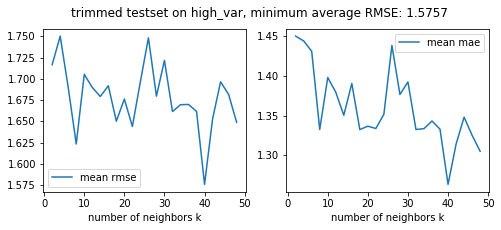

In [65]:
%%time
# the output k in this code is incorrect
from surprise.prediction_algorithms.matrix_factorization import NMF
model=NMF #only takes int, not np.int
k_list=list(range(2,50,2))
rmse_pop,mae_pop=algo_cv(model,movieData,k_list,trim='high_var')

print('min rmse is {:.4f} at k={:} latent factors, min mae is {:.4f} at k={:} latent factors.'.format(
    np.min(rmse_pop),k_list[np.argmin(rmse_pop)],np.min(mae_pop),k_list[np.argmin(mae_pop)]))

### Question 22: 
Plot the ROC curves for the NNMF-based collaborative filter
designed in question 17 for threshold values [2:5; 3; 3:5; 4]. For the ROC plot-
ting use the optimal number of latent factors found in question 18. For each of
the plots, also report the area under the curve (AUC) value.

In [88]:
# the output k in this code is incorrect
from surprise.prediction_algorithms.matrix_factorization import NMF
model=NMF(18) #only takes int, not np.int
fprs,tprs,aucs = plot_roc_curve(model,movieDataset)

finished for rating threshold:  2.5
finished for rating threshold:  3
finished for rating threshold:  3.5
finished for rating threshold:  4


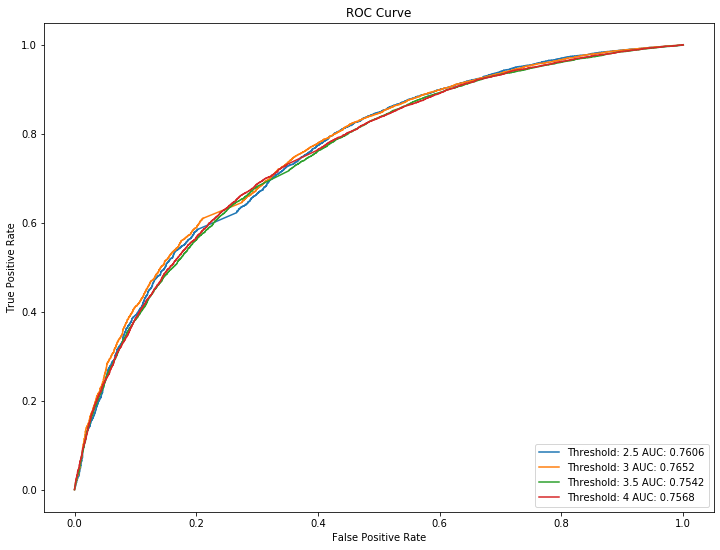

In [89]:
plt.figure(figsize=(12,9))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
for i in range(len(fprs)):
    plt.plot(fprs[i], tprs[i], label = 'Threshold: {:} AUC: {:.4f}'.format(ratingThresholds[i], aucs[i]) )
plt.legend(loc="lower right")
plt.show()

### Question 23:
Perform Non-negative matrix factorization on the ratings matrix R to obtain the factor matrices U and V , where U represents the user-latent factors interaction and V represents the movie-latent factors interaction (use k = 20). For each column of V , sort the movies in descending order and report the genres of the top 10 movies. Do the top 10 movies belong to a particular or a small collection of genre? Is there a connection between the latent factors and the movie genres?

In [92]:
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(movieData[['userId', 'movieId', 'rating']], reader).build_full_trainset()
model=NMF(20)
model.fit(data)
item_factor=model.qi
movie_orders=np.argsort(item_factor,axis=0)
top_movies=pd.DataFrame(movie_orders[-1:-11:-1 , :])
movies=pd.read_csv('ml-latest-small/movies.csv')
genres=top_movies.applymap(lambda x: movies.iloc[x]['genres'])

In [93]:
genres

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,Comedy,Comedy,Crime|Drama,Horror|Sci-Fi,Crime|Drama|Thriller,Action|Horror|Sci-Fi|Thriller,Action|Adventure|Drama,Drama,Horror,Comedy|Drama,Drama|Thriller,Drama,Crime|Drama,Comedy,Drama|Thriller,Drama,Action|Thriller,Crime|Drama|Thriller,Drama,Drama
1,Action|Comedy|Sci-Fi|IMAX,Action|Adventure|Thriller|IMAX,Documentary|Drama,Crime|Drama|Film-Noir|Thriller,Crime|Horror|Thriller,Drama,Documentary,Comedy,Drama,Comedy,Drama|Romance,Comedy,Drama|War,Action|Adventure|Fantasy,Drama,Drama|Fantasy|Horror|Romance,Documentary,Comedy|Romance,Comedy|Romance,Drama|Fantasy|Romance
2,Documentary,Drama|Musical,Comedy,Drama|Thriller|War,Drama|Mystery|Thriller,Action|Adventure|Fantasy|Thriller,Comedy|Romance,Drama,Comedy|Drama,Comedy|Crime|Thriller,Drama|Mystery,Drama,Children|Comedy,Adventure|Animation|Children|Comedy,Drama|War,Drama|Musical|Romance,Documentary,Comedy|Drama|Romance,Comedy|Drama|Fantasy|Romance,Horror|Mystery
3,Comedy,Drama|Film-Noir,Action|Animation|Film-Noir|Sci-Fi|Thriller,Drama,Drama,Drama|Romance,Horror|Thriller,Documentary|Mystery,Drama|Thriller,Action|Adventure|Fantasy,Comedy|Drama|Romance,Animation|Documentary,Action|Adventure|Comedy,Film-Noir|Thriller,Drama,Drama|Horror|Thriller,Action|Mystery|Thriller,Comedy,Action|Drama|Thriller,Drama
4,Comedy|Romance,Drama,Comedy,Comedy,Drama,Drama|Mystery|Thriller,Comedy|Drama|Romance,Adventure|Animation|Children|Fantasy,Drama,Action|Comedy,War,Action|Comedy,Horror|Thriller,Drama,Drama|Romance,Mystery|Romance|Thriller,Comedy|Drama,Drama,Action|Comedy|Drama|Thriller,Adventure|Drama|Western
5,Drama|Romance,Comedy,Drama|Mystery|Romance,Adventure|Drama,Action|Crime|Drama|Thriller,Comedy|Drama|Romance,Adventure|Drama|Sci-Fi,Action|Adventure|Comedy,Drama|Horror,Documentary,Action|Sci-Fi|Thriller,Horror|Thriller,Drama,Crime,Drama|Fantasy|Romance,Drama|Romance,Action|Comedy,Horror,Comedy|Drama|Romance,Comedy|Musical|Sci-Fi
6,Action|Crime|Drama|IMAX,Drama,Action|Drama|War,Crime|Drama|Fantasy,Comedy,Animation|Children|Comedy|Musical,Horror,Adventure|Children,Drama|Mystery,Drama,Comedy|Thriller,Documentary,Children|Comedy,Comedy|Romance,Comedy|Romance,Crime|Thriller,Action|Crime|Horror,Comedy|Drama|Romance,Comedy|Musical|Romance,Adventure|Children
7,Drama|Romance,Drama,Comedy|Crime|Drama,Drama|Musical,Comedy|Romance,Adventure|Children|Drama,Sci-Fi,Crime|Drama,Drama|Mystery|Romance|Thriller,Adventure|Comedy|Fantasy,Animation|Documentary,Drama|Mystery|Thriller,Drama|Horror|Sci-Fi|Thriller,Adventure|Drama|War,Adventure|Animation|Comedy,Crime|Drama|Thriller,Comedy|Drama|Thriller,Adventure|Animation|Children|Fantasy|Musical|R...,Crime|Mystery|Thriller,Crime|Drama|Thriller
8,Action|Adventure|Sci-Fi|IMAX,Action|Adventure|Sci-Fi,Drama|Film-Noir|Mystery,Comedy|Romance,Drama,Comedy|Romance,Action|Horror|Mystery|Sci-Fi,Romance|Sci-Fi,Comedy|Drama|Romance,Crime|Mystery,Action|Comedy|Crime|Thriller,Drama,Drama,Action|Comedy,Comedy|Fantasy|Horror,Comedy|Drama,Comedy|Romance,Horror|Sci-Fi|Thriller,Drama,Drama|Fantasy|Romance
9,Comedy,Action|Sci-Fi|Thriller,Documentary,Comedy|Romance,Action|Adventure|Drama|War,Comedy|Drama|Romance,Drama|War,Crime|Drama,Drama,Drama|Film-Noir|Mystery|Thriller,Drama|Musical,Comedy,Animation|Children|Fantasy|Musical,Action|Adventure|Drama|Thriller,Horror|Mystery|Thriller,Drama,Drama,Documentary,Comedy|Romance,Drama
